## Early stopping
In a typical A/B test, one faces the challenge to evaluate the performance of different variants as often as possible, one also has the incentive to make decisions faster and to stop the experiment as early as possible in the following cases:
- Clear overperformance of the alternative variant, to reduce the experiment cost
- Clear overperformance of the control variant, to reduce the negative impact

However, it is not a valid approach to simply peek into the data continuously over time, which will cause an inflated false positive rate. We illustrate this effect by means of a simulation and propose alternatives using the Bayesian approach.



In [2]:
from simulate import *
import seaborn as sns
sns.set(font_scale=1.5)
%matplotlib inline

ExpAn core init: v0.4.4


### Simulation
We simulate an A/A test where there is no difference between the two variants. More specifically, we define the split between variants to be A (control): 60%, B: 40%. At each time step, a random subset of all entities is selected and their KPI values sampled (with a fixed sampling rate) from the distribution 
$$
\mathcal{N}(0,1)
$$
for both variants. We first present two frequentist approaches to evaluate the experiment:

### Fixed horizon
At the end of the experiment, we aggregate the KPI on the entity level over time and calculate the difference and the 95% confidence interval between variants. If we repeat the experiment multiple times, we observe a false positive rate of ~5%, where a statistically significant difference is detected.

In [13]:
# from expan.core.experiment import Experiment

# metadata = {'source': 'simulation', 'experiment': 'random'}
# diff = [True]*sims
# for i in range(sims):
#     dat = generate_random_data(i)
#     # fixed-horizon
#     kpi = get_snapshot(dat, days+1)
#     exp = Experiment('A', kpi, metadata)
#     res = exp.delta(kpi_subset=['normal_same'])
#     interval = res.statistic('delta', 'uplift_pctile', 'normal_same').loc[:,('value','B')]
#     if np.sign(interval[0])*np.sign(interval[1]) > 0:
#     	diff[i] = True
#     else:
#     	diff[i] = False
        
diff = pd.read_csv('/home/jbao/slurm/src/early-stopping/fixed_horizon/fixed_horizon.csv', header=None, 
                   names=['value'], dtype={'value':np.bool})
print('Difference detected: '+str(diff.sum().iloc[0])+'/'+str(sims))

Difference detected: 5/100


### Optional stopping
Next up, we adopt the strategy to peek into the data and perform the frequentist calculation at each time step, and declare the end of the experiment as soon as we observe a significant change between variants. If we repeat the experiment the same way, we observe a false positive rate of ~25%, more than 4 times higher than the fixed horizon approach.

In [14]:
# overall_diff = [True]*sims
# for i in range(sims):
#     dat = generate_random_data(i)
#     diff = [True]*days
#     # optional stopping
#     for d in range(days):
#     	kpi = get_snapshot(dat, d+1)
#     	exp = Experiment('A', kpi, metadata)
#     	res = exp.delta(kpi_subset=['normal_same'])
#     	interval = res.statistic('delta', 'uplift_pctile', 'normal_same').loc[:,('value','B')]
#     	if np.sign(interval[0])*np.sign(interval[1]) > 0:
#     		diff[d] = True
#     	else:
#     		diff[d] = False
#     if sum(diff) > 0:
#         overall_diff[i] = True
#     else:
#         overall_diff[i] = False
        
diff = pd.read_csv('/home/jbao/slurm/src/early-stopping/optional_stopping/optional_stopping.csv', header=None, 
                   names=['value'], dtype={'value':np.bool})
print('Difference detected: '+str(diff.sum().iloc[0])+'/'+str(sims))

Difference detected: 20/100


### Group sequential testing

Group sequential methods aim to perform statistical hypothesis tests at various time points before the predefined sample size is reached, while keeping the total false positive rate constant. It redistributes the error rate $\alpha$ over time by a spending function. An $\alpha$ spending function starts at 0 when the information fraction is 0 and reaches $\alpha$ when the information fraction is 1, it can have arbitrary curvatures and two common forms are:

- O'Brien-Fleming (more conservative)
- Pocock

Once the time-specific $\alpha$s are calculated, they can then be converted to the z-score thresholds.

#### False positive rate

In [29]:
# calculated with bounds(seq(0.05,1,length=20),iuse=c(1,1),alpha=c(0.025,0.025)) in R
bounds = [8.000000, 8.000000, 8.000000, 4.915742, 4.336773, 3.942483, 3.638028, 3.394052, 3.193264, 3.024348, 
          2.879692, 2.753971, 2.643399, 2.545164, 2.457130, 2.377652, 2.305414, 2.239395, 2.178743, 2.122766]

def gst(kpi_name):
    zscore = pd.DataFrame()
    overall_diff = [True]*sims
    for i in range(sims):
        dat = generate_random_data(i)
        diff = [True]*days
        # optional stopping
        for d in range(days):
            kpi = get_snapshot(dat, d+1)
            ctrl = kpi.loc[kpi.variant=='A',kpi_name]
            treat = kpi.loc[kpi.variant=='B',kpi_name]
            mu_c = ctrl.mean()
            mu_t = treat.mean()
            sigma_c = ctrl.std()
            sigma_t = treat.std()
            n_c = len(ctrl)
            n_t = len(treat)
            z = (mu_t-mu_c) / np.sqrt(sigma_c**2/n_c+sigma_t**2/n_t)
            
            if z > bounds[d] or z < -bounds[d]:
                diff[d] = True
            else:
                diff[d] = False
                
            zscore = zscore.append(pd.DataFrame({'z':z,'sim':i,'day':d,'delta':mu_t-mu_c,'significant':diff[d]},
                                                index=[0]), ignore_index=True)
                
        if sum(diff) > 0:
            overall_diff[i] = True
        else:
            overall_diff[i] = False

    print('Difference detected: '+str(sum(overall_diff))+'/'+str(sims))
    return zscore
    
#zscore = gst('normal_same')
gs_results = pd.read_csv('/home/jbao/slurm/src/early-stopping/group_sequential/group_sequential_normal_same.csv', 
                         header=None, names=['significant','delta'])
gs_results.loc[:,'day'] = range(days)*sims
gs_results.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
stopped = gs_results.groupby('sim').significant.agg({'val':lambda x:any(x)})

print('Difference detected: '+str(sum(stopped.iloc[:,0]))+'/'+str(sims))

Difference detected: 5/100


#### Power

In [30]:
gs_results = pd.read_csv('/home/jbao/slurm/src/early-stopping/group_sequential/group_sequential_normal_shifted.csv', 
                         header=None, names=['significant','delta'])
gs_results.loc[:,'day'] = range(days)*sims
gs_results.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
stopped = gs_results.groupby('sim').significant.agg({'val':lambda x:any(x)})

print('Difference detected: '+str(sum(stopped.iloc[:,0]))+'/'+str(sims))

Difference detected: 100/100


#### Bias

In [ ]:
gs_results = pd.read_csv('/home/jbao/slurm/src/early-stopping/group_sequential/group_sequential_normal_shifted.csv', 
                         header=None, names=['significant','delta'])
gs_results.loc[:,'day'] = range(days)*sims
gs_results.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
fixed_delta = gs_results.delta[(gs_results.day==19)&(gs_results.significant==True)]
early_delta = gs_results[gs_results.significant].groupby('sim',as_index=False).first().delta
sns.distplot(fixed_delta)
sns.distplot(early_delta)
mu = 1
lam = 3
true_delta = lam/(1-np.exp(-lam))*mu
sns.plt.plot([true_delta,true_delta],[0,12],'r--')

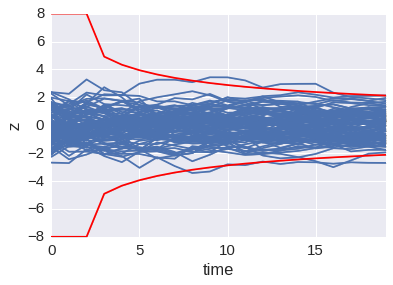

In [24]:
for i in range(sims):
    df = zscore[zscore.sim==i]
    sns.tsplot(df.z)
sns.tsplot(bounds, color='r')
sns.tsplot([-x for x in bounds], color='r')
sns.plt.xlabel('time')
sns.plt.ylabel('z')

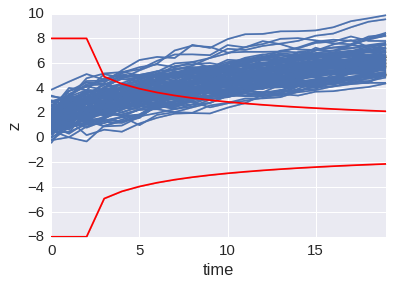

In [26]:
for i in range(sims):
    df = zscore[zscore.sim==i]
    sns.tsplot(df.z)
sns.tsplot(bounds, color='r')
sns.tsplot([-x for x in bounds], color='r')
sns.plt.xlabel('time')
sns.plt.ylabel('z')

### Bayes factor
One option to constantly peek into and optionally stop the experiment with a controlled false positive rate is using the Bayesian approach, or more specifically the Bayes factor. Assume the null hypothesis $H_0$, the alternative hypothesis $H_1$ and observed data $D$, the Bayes rule is defined as
$$
p(H_1|D) \sim p(D|H_1)p(H_1)
$$
and the ratio of the posterior densities
$$
\frac{p(H_0|D)}{p(H_1|D)}=\frac{p(H_0)}{p(H_1)}\frac{p(D|H_0)}{p(D|H_1)}
$$
and the ratio of the marginal likelihoods
$$
BF_{01}=\frac{p(D|H_0)}{p(D|H_1)}
$$
is also called the Bayes factor, which quantifies the relative likelihood, or weight of evidence based on the data. If there is no prior bias in the hypotheses (the ratio of priors equals 1), the Bayes factor is also the ratio of the posteriors.

Let $H_0: \phi=\phi_0, H_1: \phi \neq \phi_0$ and $\psi$ is a nuisance parameter, which is a nested model, it follows:
$$
p_1(\psi|\phi=\phi_0)=p_0(\psi)
$$
One can further derive
$$
BF_{01}=\frac{p_0(D)}{p_1(D)}=\frac{p_1(\phi=\phi_0|D)}{p_1(\phi=\phi_0)}
$$
which is called the **Savage-Dickey density ratio**.

We further consider the following model, let $\mu$ be the population mean and $\sigma$ the population variance, $x$ and $y$ are the observed KPIs for the control and treatment variant respectively
$$
x \sim \mathcal{N}(\mu-\frac{\alpha}{2},\sigma^2)\\
y \sim \mathcal{N}(\mu+\frac{\alpha}{2},\sigma^2)
$$
Therefore the difference in mean is $\alpha$, we also define a dimensionless effect size $\delta=\alpha/\sigma$ with the following priors
$$
\mu \sim Cauchy(0,1)\\
\delta \sim Cauchy(0,1)
$$
And the hypotheses we are comparing are: $H_0: \delta=0, H_1: \delta \neq 0$

In [22]:
# perform the fit
#fit_data = {'Nc': sum(df.variant=='A'), 
#            'Nt': sum(df.variant=='B'), 
#            'Vc': df['visits'][df.variant=='A'], 
#            'Vt': df['visits'][df.variant=='B'],
#            'Oc': df['orders_shifted'][df.variant=='A'], 
#            'Ot': df['orders_shifted'][df.variant=='B']}
sm = StanModel(file='normal_kpi.stan')
dat = generate_random_data(1)
#df = get_snapshot(dat, days+1)
df = get_snapshot(dat, 8)
#fit_data = {'Nc': sum(df.variant=='A'), 
#            'Nt': sum(df.variant=='B'), 
#            'x': df['normal_same'][df.variant=='A'], 
#            'y': df['normal_same'][df.variant=='B']}
fit, traces = fit_stan(sm, df, 'normal_shifted')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_574dc31778b5ab9d7948544f3c92a063 NOW.


(1.1602538013934223, 1.2299281957597892)


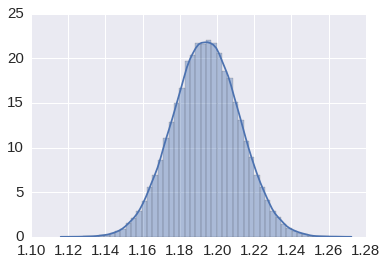

In [23]:
x = traces['delta']
print(HDI_from_MCMC(x))
#max(x)
#x.tofile('data/delta_trace_day_100.csv','\n')
sns.distplot(x)

The posterior density of $\delta$ is sampled by the Monte Carlo method, and we calculate the 95% highest density interval based on the posterior distribution.

array([ 16.49796704])

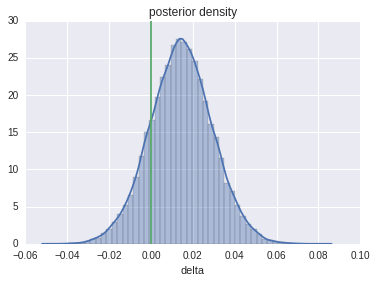

In [14]:
kde = gaussian_kde(delta_trace)
#fig, ax = sns.plt.subplots()
sns.distplot(delta_trace, axlabel='delta')
sns.plt.title('posterior density')
sns.plt.plot([0,0],[0,30])
post = kde.evaluate([0])
post

The prior of $\delta$ is Cauchy distributed.

0.3183098861837907

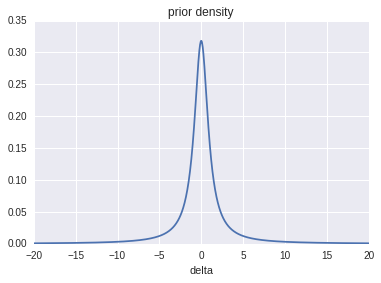

In [11]:
#x = cauchy.rvs(size=1000)
x = np.linspace(-20,20,1000)
f = lambda x: 1/(np.pi*(1+x**2))
#sns.plt.hist(x)
sns.plt.plot(x,f(x))
sns.plt.xlabel('delta')
sns.plt.title('prior density')
#sns.plt.plot([0,0],[0,0.4])
prior = f(0)
prior

In [25]:
print('BF_01=%.2e'%(post/prior))

BF_01=7.54e+01


We then simulate the same peeking and optional stopping strategy with the Bayes factor approach.

#### Type-I error (false positive rate in an A/A experiment)

Difference detected: 1.0/100


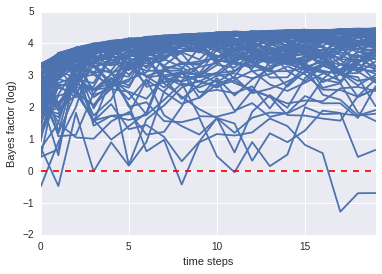

In [12]:
bf = pd.read_csv('bayes_factor.csv', header=None, names=['value'])
#bf = pd.read_csv('bayes_factor_20161124185643.csv', header=None, names=['value'])
bf.loc[:,'day'] = range(days)*sims
bf.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
#sns.tsplot(bf, time='day', value='value', condition='sim')
for i in range(sims):
    df = bf[bf.sim==i]
    sns.tsplot(np.log(df.value))
sns.plt.plot([0,20],[0,0],'r--')
sns.plt.xlabel('time steps')
sns.plt.ylabel('Bayes factor (log)')
diff = bf.groupby('sim').value.agg({'val':lambda x:any(x<1/3.)})

print('Difference detected: '+str(sum(diff.iloc[:,0]))+'/'+str(sims))

#### Power (true positive rate in an A/B experiment)

Difference detected: 99.0/100


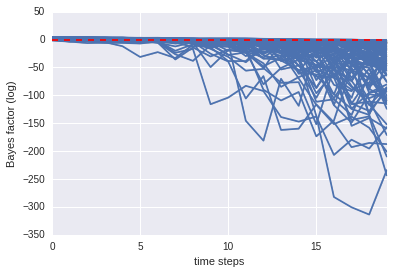

In [27]:
bf = pd.read_csv('/home/jbao/slurm/src/early-stopping/data/bayes_factor_normal_shifted_20161201151609.csv', header=None, names=['value'])
bf.loc[:,'day'] = range(days)*sims
bf.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
#sns.tsplot(bf, time='day', value='value', condition='sim')
for i in range(sims):
    df = bf[bf.sim==i]
    sns.tsplot(np.log(df.value))
sns.plt.plot([0,20],[0,0],'r--')
sns.plt.xlabel('time steps')
sns.plt.ylabel('Bayes factor (log)')
diff = bf.groupby('sim').value.agg({'val':lambda x:any(x<1/3.)})

print('Difference detected: '+str(sum(diff.iloc[:,0]))+'/'+str(sims))

Investigate the relationship between Type-I error/power and different **Parameters**: 
- shape of the prior under $H_1$: Normal, Cauchy
- scale of the prior under $H_1$

#### Sensitivity analysis

In [3]:
distribution = ["cauchy", "normal"]
scale = ['1.0', '2.0', '5.0', '10.0']

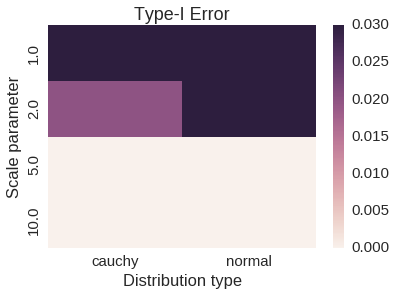

In [10]:
fp = np.zeros((len(scale),len(distribution)))
for i in range(len(scale)):
    for j in range(len(distribution)):
        dat = pd.read_csv('/home/jbao/slurm/src/early-stopping/bayes_factor/bayes_factor_normal_same_'+
                          distribution[j]+'_'+scale[i]+'.csv', header=None, names=['value'])
        dat.loc[:,'day'] = range(days)*sims
        dat.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
        diff = dat.groupby('sim').value.agg({'val':lambda x:any(x<1/3.)})

        fp[i,j] = sum(diff.iloc[:,0])/float(sims)
        
sns.heatmap(fp, xticklabels=distribution, yticklabels=scale)
sns.plt.xlabel('Distribution type')
sns.plt.ylabel('Scale parameter')
sns.plt.title('Type-I Error')

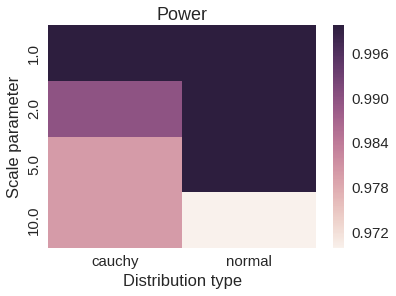

In [11]:
power = np.zeros((len(scale),len(distribution)))
for i in range(len(scale)):
    for j in range(len(distribution)):
        dat = pd.read_csv('/home/jbao/slurm/src/early-stopping/bayes_factor/bayes_factor_normal_shifted_'+
                          distribution[j]+'_'+scale[i]+'.csv', header=None, names=['value'])
        dat.loc[:,'day'] = range(days)*sims
        dat.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
        diff = dat.groupby('sim').value.agg({'val':lambda x:any(x<1/3.)})

        power[i,j] = sum(diff.iloc[:,0])/float(sims)
        
sns.heatmap(power, xticklabels=distribution, yticklabels=scale)
sns.plt.xlabel('Distribution type')
sns.plt.ylabel('Scale parameter')
sns.plt.title('Power')

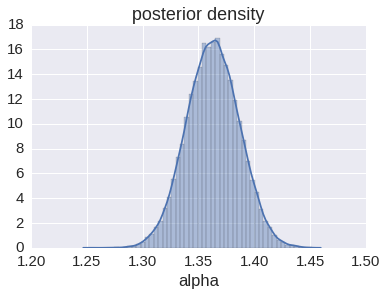

In [6]:
alpha_trace = traces['alpha']
kde = gaussian_kde(alpha_trace)
sns.distplot(alpha_trace, axlabel='alpha')
sns.plt.title('posterior density')

### Parameter estimation
Investigate the relationship between Type-I error/power and different **Parameters**: 
- width of ROPE
- mass of HDI


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5eed0053057de474c9fedd912520e983 NOW.


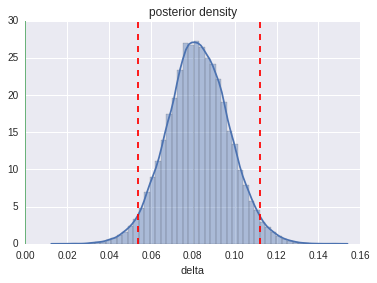

In [15]:
sm = StanModel(file='normal_kpi.stan')
dat = generate_random_data(1)
df = get_snapshot(dat, days+1)
fit_data = {'Nc': sum(df.variant=='A'), 
            'Nt': sum(df.variant=='B'), 
            'x': df['normal_shifted'][df.variant=='A'], 
            'y': df['normal_shifted'][df.variant=='B']}
fit, delta_trace = fit_stan(sm, fit_data)
hdi = HDI_from_MCMC(delta_trace, 0.95)

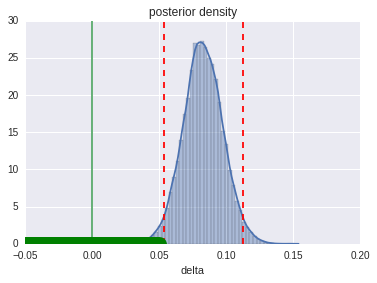

In [19]:
rope_width = 0.1
sns.distplot(delta_trace, axlabel='delta')
sns.plt.title('posterior density')
sns.plt.plot([0,0],[0,30])
sns.plt.plot([hdi[0],hdi[0]],[0,30],'r--')
sns.plt.plot([hdi[1],hdi[1]],[0,30],'r--')
sns.plt.plot([-rope_width/2,rope_width/2],[0,0],'g',linewidth=15)

#### Type-I error (false positive rate in an A/A experiment)

In [2]:
bf = pd.read_csv('/home/jbao/slurm/src/early-stopping/data/hdi_rope_normal_same_20161205132212.csv', header=None, names=['value'])
bf.loc[:,'day'] = range(days)*sims
bf.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
diff = bf.groupby('sim').value.agg({'val':lambda x:any(x=='outside')})

print('Difference detected: '+str(sum(diff.iloc[:,0]))+'/'+str(sims))

Difference detected: 0/100


#### Power (true positive rate in an A/B experiment)

#### Sensitivity analysis

In [33]:
rope_width = [0.06, 0.08, 0.1, 0.12, 0.14]
hdi_mass = [0.8, 0.85, 0.9, 0.95]

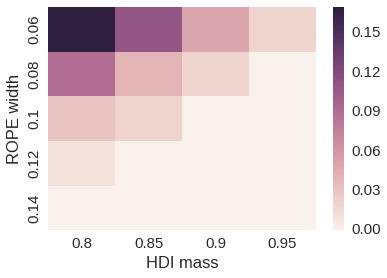

In [36]:
fp = np.zeros((len(rope_width),len(hdi_mass)))
for i in range(len(rope_width)):
    for j in range(len(hdi_mass)):
        dat = pd.read_csv('/home/jbao/slurm/src/early-stopping/hdi_rope/hdi_rope_normal_same_'+str(rope_width[i])+'_'+str(hdi_mass[j])+'.csv', header=None, names=['value'])
        dat.loc[:,'day'] = range(days)*sims
        dat.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
        diff = dat.groupby('sim').value.agg({'val':lambda x:any(x=='outside')})

        fp[i,j] = sum(diff.iloc[:,0])/float(sims)
        
sns.heatmap(fp, xticklabels=hdi_mass, yticklabels=rope_width)
sns.plt.xlabel('HDI mass')
sns.plt.ylabel('ROPE width')

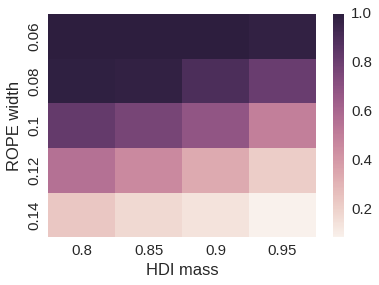

In [35]:
power = np.zeros((len(rope_width),len(hdi_mass)))
for i in range(len(rope_width)):
    for j in range(len(hdi_mass)):
        dat = pd.read_csv('/home/jbao/slurm/src/early-stopping/hdi_rope/hdi_rope_normal_shifted_'+str(rope_width[i])+'_'+str(hdi_mass[j])+'.csv', header=None, names=['value'])
        dat.loc[:,'day'] = range(days)*sims
        dat.loc[:,'sim'] = [val for val in range(sims) for _ in range(days)]
        diff = dat.groupby('sim').value.agg({'val':lambda x:any(x=='outside')})

        power[i,j] = sum(diff.iloc[:,0])/float(sims)
        
sns.heatmap(power, xticklabels=hdi_mass, yticklabels=rope_width)
sns.plt.xlabel('HDI mass')
sns.plt.ylabel('ROPE width')

### Alternative model (rate metric)

Next we apply Bayesian hypothesis testing on a rate metric (e.g. conversion rate, return rate). In the case of the return rate, we assume the number of returned articles is drawn from a binomial distribution
$$
s \sim Binomial(t, \theta)
$$
where $t$ is the total number of bought articles and $\theta$ is the return rate. What we are interested in is the difference in the return rate of the treatment and control variant $\theta_t-\theta_c$. However, since the values of $\theta$ are bounded by 0 and 1, it is difficult to define a prior and sample from the posterior. Therefore, we first transform $\theta \in [0,1]$ to a continuous scale $\phi \in \mathbb{R}$. (It makes no difference to use the logit or probit transform.)

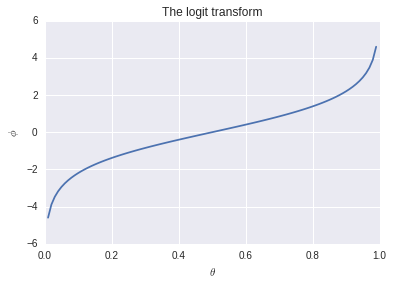

In [9]:
x = np.arange(0,1,0.01)
sns.plt.plot(x, np.log(x/(1-x)))
sns.plt.xlabel(r'$\theta$')
sns.plt.ylabel(r'$\phi$')
sns.plt.title('The logit transform')

We then define the difference in $\phi$ as
$$
\alpha = \phi_t - \phi_c
$$
and assign a normal prior
$$
\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^{2})
$$
Thus the effect size of interest is
$$
\delta = \mu_{\alpha} / \sigma_{\alpha}
$$
with the Cauchy prior
$$
\delta \sim Cauchy(0,1)
$$

In [29]:
sm = StanModel(file='rate_kpi.stan')
df = pd.read_csv('size39_sales_kpi_over_time.csv')
df = df[df.ARTICLES_ORDERED!=0]
fit_data = {'Nc': sum(df.variant=='hide'), 
            'Nt': sum(df.variant=='show'), 
            't_c': df['ARTICLES_ORDERED'][df.variant=='hide'], 
            't_t': df['ARTICLES_ORDERED'][df.variant=='show'],
            's_c': df['ARTICLES_RETURNED'][df.variant=='hide'].astype(int), 
            's_t': df['ARTICLES_RETURNED'][df.variant=='show'].astype(int)
           }
fit, delta_trace = fit_stan(sm, fit_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f929b2788bbe3c118581fb4f9e04446 NOW.


BF_01=1.68e+00


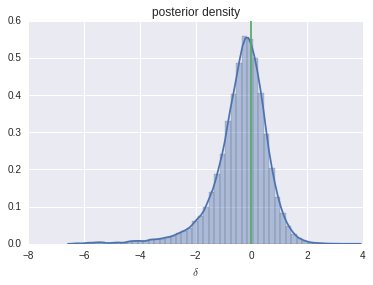

In [13]:
kde = gaussian_kde(delta_trace)
#fig, ax = sns.plt.subplots()
sns.distplot(delta_trace, axlabel=r'$\delta$')
sns.plt.title('posterior density')
sns.plt.plot([0,0],[0,0.6])
post = kde.evaluate([0])
f = lambda x: 1/(np.pi*(1+x**2))
prior = f(0)
print('BF_01=%.2e'%(post/prior))

#### Mixture model?

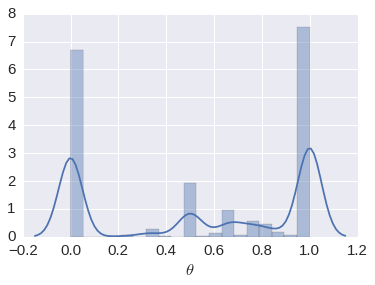

In [31]:
sns.distplot(df.ARTICLES_RETURNED/df.ARTICLES_ORDERED)
sns.plt.xlabel(r'$\theta$')